# Cross-Validation Results Report — PLUS

This notebook:
1) loads a Random Forest cross-validation results `.pkl` (robust to NumPy/sklearn version issues),
2) renames features, computes metrics per fold,
3) generates diagnostic plots (true vs predicted, residuals, boxplots, importance stability heatmap),
4) identifies the **best fold** and exports a **mini-report**,
5) builds an **HTML report** with tables, text and images,
6) produces a **single collage** combining the 5 scatter plots (top) and the 5 residual plots (bottom).

In [ ]:
'''FOR ANY PROBLEM WITH THE ORIGINAL .CSV FILE'''

# import pandas as pd
# df = pd.read_excel("/Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Intermediate_data/ML/Effectiveness.ods", sheet_name=0, dtype=str)  # carica tutto come stringhe per non perdere formattazione
# df.to_csv("/Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Intermediate_data/Effectiveness_clean.csv", index=False)                  # separatore “,”, quoting gestito da pandas


In [328]:
# --- Configuration ---
file_path = r"/Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/data/univariate/NPSI_target/univ_NPSI_effectiveness_singleoutput_baseline_rs42.pkl"

# to choose basing on the geature labels of interest

# feature_labels = ["FL","FR","CL","CR","TR","TL","PR","PL","OL","OR"] 
feature_labels = ['criq', 'mmse', 'trog', 'reyfig', 'reyword', 'phonemic', 'semantic', 'denomdescr', 'span_for', 'span_back'] 
# feature_labels = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30', 'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40', 'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E56', 'E57', 'E58', 'E59', 'E60', 'E61', 'E62', 'E63', 'E64', 'E65', 'E66', 'E68', 'E69', 'E70', 'E71', 'E72', 'E74', 'E75', 'E76', 'E77', 'E78', 'E79', 'E80', 'E81', 'E83', 'E84', 'E85', 'E86', 'E87', 'E88', 'E89', 'E90', 'E93', 'E94', 'E95', 'E96', 'E97', 'E98', 'E99', 'E100', 'E101', 'E103', 'E104', 'E105', 'E106', 'E107', 'E108', 'E109', 'E110', 'E112', 'E113', 'E114', 'E115', 'E116', 'E117', 'E118', 'E119', 'E121', 'E122', 'E123', 'E124', 'E125', 'E126', 'E127', 'E128', 'E129', 'E130', 'E131', 'E132', 'E134', 'E135', 'E136', 'E137', 'E138', 'E139', 'E140', 'E141', 'E142', 'E143', 'E144', 'E146', 'E147', 'E148', 'E149', 'E150', 'E151', 'E152', 'E153', 'E154', 'E155', 'E156', 'E157', 'E158', 'E159', 'E160', 'E161', 'E162', 'E163', 'E164', 'E166', 'E167', 'E168', 'E169', 'E170', 'E171', 'E172', 'E173', 'E175', 'E176', 'E177', 'E178', 'E179', 'E180', 'E181', 'E182', 'E183', 'E184', 'E185', 'E186', 'E188', 'E189', 'E190', 'E191', 'E192', 'E193', 'E194', 'E195', 'E196', 'E197', 'E198', 'E200', 'E201', 'E202', 'E203', 'E204', 'E205', 'E206', 'E207', 'E210', 'E211', 'E212', 'E213', 'E214', 'E215', 'E220', 'E221', 'E222', 'E223', 'E224']
out_dir = "/Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_NPSI_effectiveness"
print("Using file:", file_path)

Using file: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/data/univariate/NPSI_target/univ_NPSI_effectiveness_singleoutput_baseline_rs42.pkl


In [329]:
# --- Robust PKL loader for numpy/sklearn version differences ---
import pickle, os

class DummySklearnTree:
    def __init__(self, *args, **kwargs):
        pass
    def __setstate__(self, state):
        self._placeholder = True

class SafeUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module.startswith("numpy._core"):
            module = module.replace("numpy._core", "numpy.core")
        if module == "sklearn.tree._tree" and name == "Tree":
            return DummySklearnTree
        return super().find_class(module, name)

os.makedirs(out_dir, exist_ok=True)

with open(file_path, "rb") as f:
    data = SafeUnpickler(f).load()

if isinstance(data, dict) and len(data) == 1:
    model_key = list(data.keys())[0]
    print("Model key found:", model_key)
    rf = data[model_key]
elif isinstance(data, dict) and "cv_fold_predictions" in data:
    rf = data
    print("Loaded direct results dict")
else:
    raise ValueError("Unexpected PKL structure.")
type(rf), list(rf.keys())

Model key found: Random Forest


(dict,
 ['cv_fold_scores',
  'cv_fold_importances',
  'cv_fold_predictions',
  'cv_fold_estimators',
  'model_name',
  'params',
  'predictions',
  'metric_scores'])

In [330]:
# --- Feature importances: build DataFrame (fold x feature) ---
import numpy as np
import pandas as pd

imp = rf.get("cv_fold_importances", {})
df_imp = pd.DataFrame(imp)
if df_imp.shape[1] == len(feature_labels):
    df_imp.columns = feature_labels
else:
    df_imp.columns = feature_labels[:df_imp.shape[1]]
df_imp.index.name = "Fold"

display(df_imp.head())
df_imp.to_csv(os.path.join(out_dir, "feature_importances_by_fold.csv"), index=True)

imp_mean = df_imp.mean(axis=0)
imp_std  = df_imp.std(axis=0)
imp_stats = pd.DataFrame({"feature": df_imp.columns, "mean_importance": imp_mean.values, "std_importance": imp_std.values}).sort_values("mean_importance", ascending=False)
display(imp_stats)
imp_stats.to_csv(os.path.join(out_dir, "feature_importances_mean_std.csv"), index=False)

,criq,mmse,trog,reyfig,reyword,phonemic,semantic,denomdescr,span_for,span_back
Fold,,,,,,,,,,
0,0.176186,0.036248,0.095054,0.086813,0.130574,0.052616,0.110754,0.173530,0.086111,0.052116
1,0.092214,0.049166,0.038126,0.122381,0.139923,0.069003,0.310188,0.070049,0.055751,0.053199
2,0.128029,0.045923,0.051575,0.073161,0.333036,0.090448,0.103583,0.111156,0.039609,0.023480
3,0.106676,0.032722,0.063410,0.159165,0.151191,0.068679,0.261321,0.070862,0.060117,0.025857
4,0.255968,0.040798,0.040408,0.120489,0.058669,0.057056,0.249585,0.072322,0.071185,0.033520


,feature,mean_importance,std_importance
6,semantic,0.207086,0.094035
4,reyword,0.162679,0.101882
0,criq,0.151815,0.066328
3,reyfig,0.112402,0.033714
7,denomdescr,0.099584,0.044840
5,phonemic,0.067560,0.014670
8,span_for,0.062555,0.017379
2,trog,0.057715,0.023171
1,mmse,0.040971,0.006746
9,span_back,0.037634,0.014212


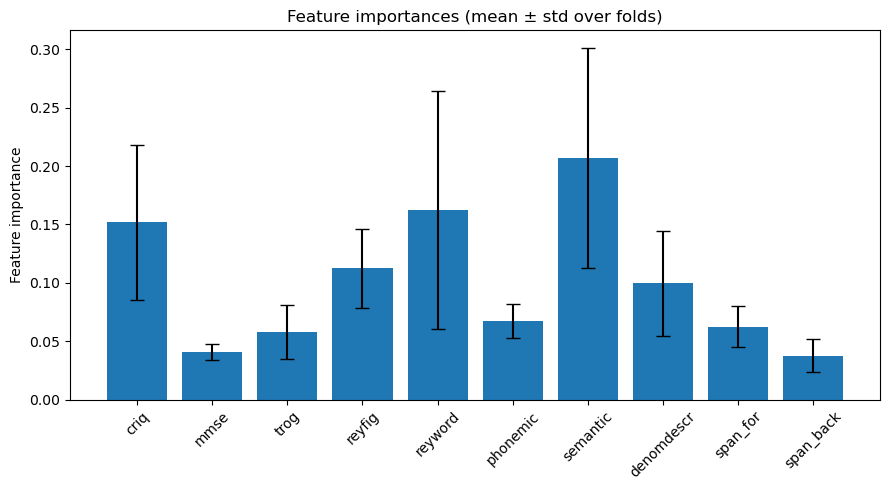

In [331]:
# --- Plot: Feature importances (mean ± std) ---
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9,5))
x = np.arange(len(df_imp.columns))
plt.bar(x, imp_mean.values, yerr=imp_std.values, capsize=5)
plt.xticks(x, df_imp.columns, rotation=45)
plt.ylabel("Feature importance")
plt.title("Feature importances (mean ± std over folds)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "feature_importances_mean_std.png"), dpi=150)
plt.show()

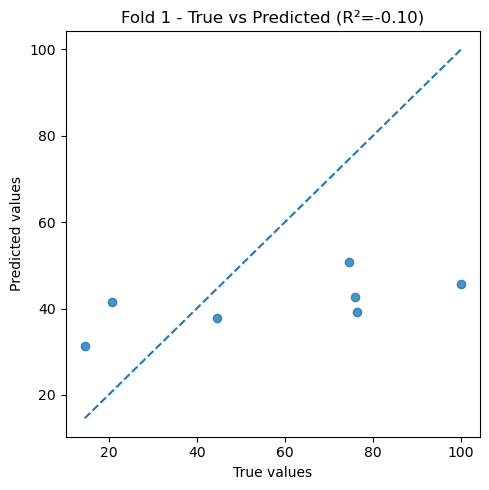

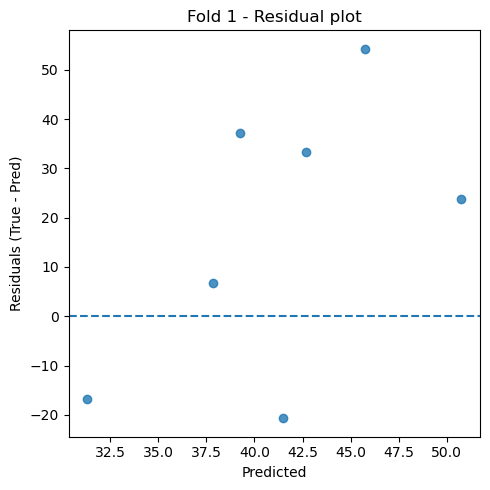

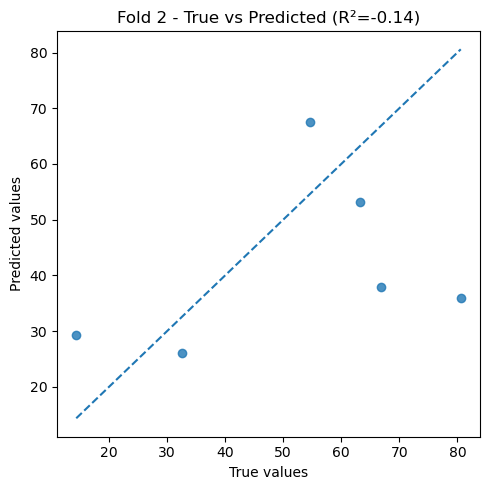

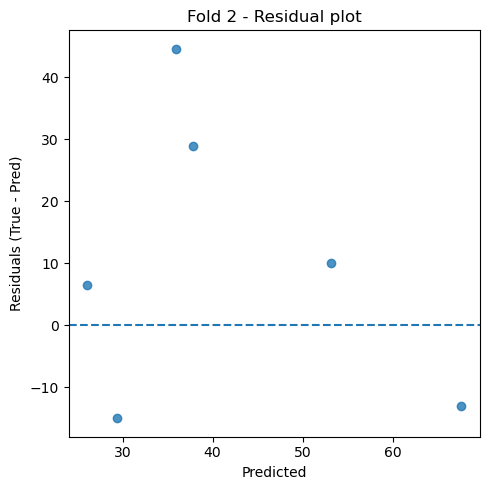

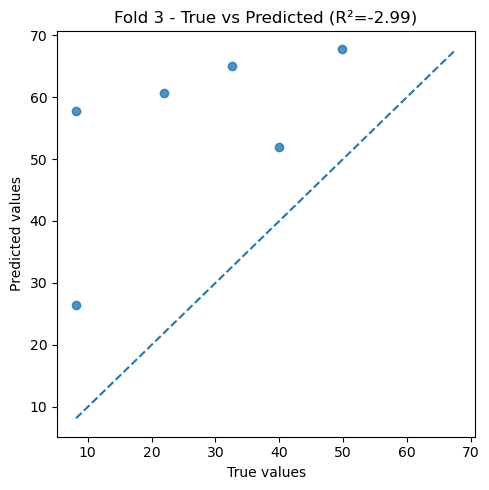

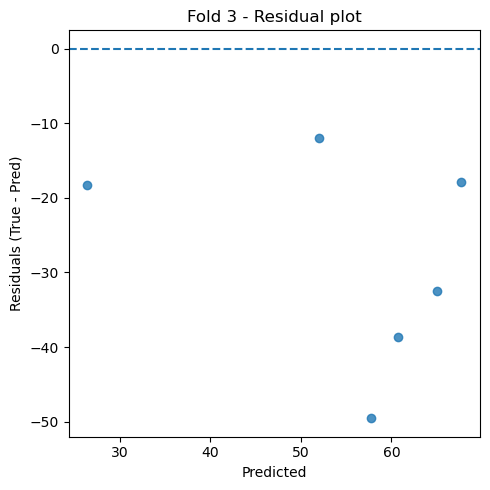

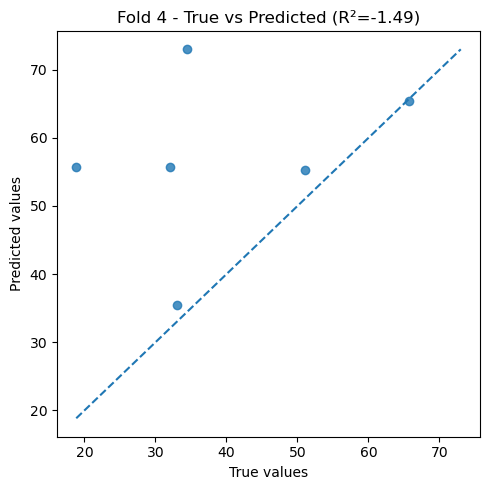

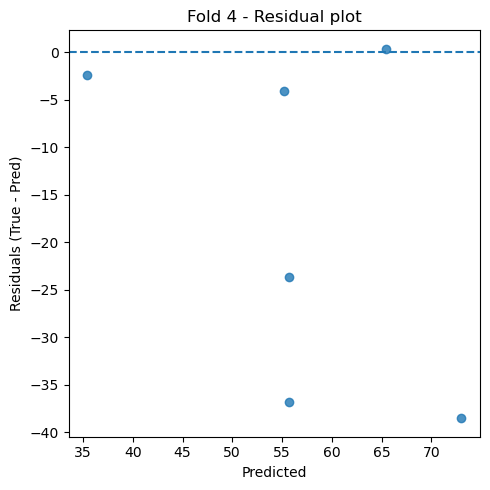

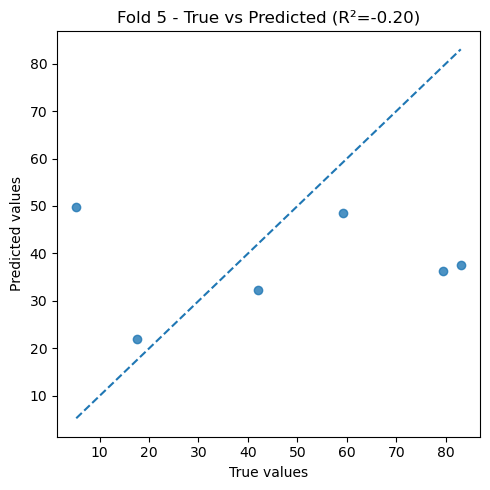

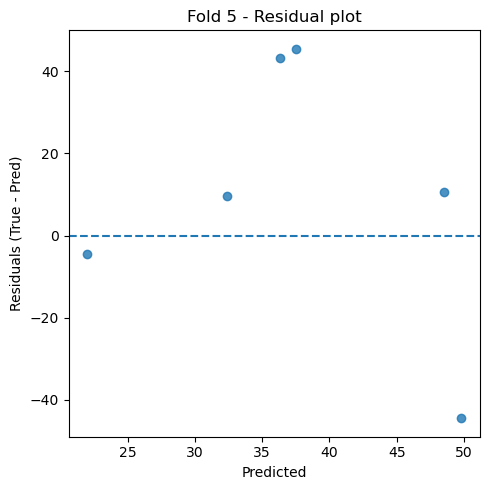

,Fold,R2,MSE,RMSE,MAE
0,1,-0.098209,965.045776,31.065186,27.527235
1,2,-0.136526,561.643343,23.699016,19.699787
2,3,-2.989105,967.299156,31.101433,28.144406
3,4,-1.494737,570.864164,23.892764,17.648310
4,5,-0.196133,1022.983906,31.984120,26.337461


In [332]:
# --- Predictions per fold + metrics ---
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

fold_preds = rf.get("cv_fold_predictions", [])
metrics = []

for i, fold in enumerate(fold_preds):
    y_true = np.array(fold["y_true"]).ravel()
    y_pred = np.array(fold["y_pred"]).ravel()
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    metrics.append({"Fold": i+1, "R2": float(r2), "MSE": float(mse), "RMSE": rmse, "MAE": float(mae)})

    # Scatter true vs pred
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.8)
    mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx], linestyle="--")
    plt.xlabel("True values")
    plt.ylabel("Predicted values")
    plt.title(f"Fold {i+1} - True vs Predicted (R²={r2:.2f})")
    plt.tight_layout()
    pth = os.path.join(out_dir, f"fold_{i+1}_true_vs_pred.png")
    plt.savefig(pth, dpi=150)
    plt.show()

    # Residual plot
    residuals = y_true - y_pred
    plt.figure(figsize=(5,5))
    plt.scatter(y_pred, residuals, alpha=0.8)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals (True - Pred)")
    plt.title(f"Fold {i+1} - Residual plot")
    plt.tight_layout()
    rp = os.path.join(out_dir, f"fold_{i+1}_residuals.png")
    plt.savefig(rp, dpi=150)
    plt.show()

df_metrics = pd.DataFrame(metrics)
display(df_metrics)
df_metrics.to_csv(os.path.join(out_dir, "metrics_by_fold.csv"), index=False)

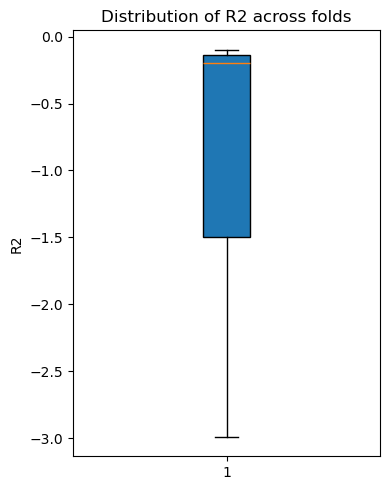

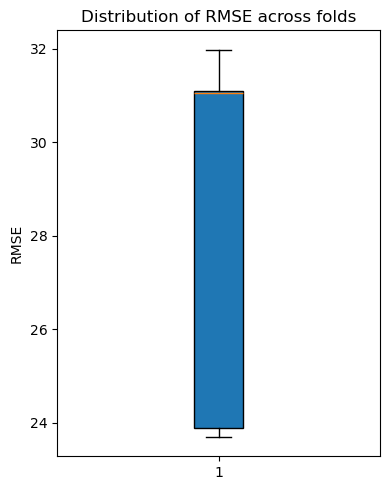

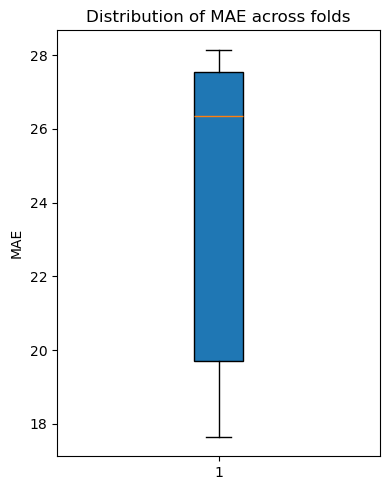

In [333]:
# --- Boxplots for metrics ---
import matplotlib.pyplot as plt
import os

for metric_name in ["R2", "RMSE", "MAE"]:
    plt.figure(figsize=(4,5))
    plt.boxplot(df_metrics[metric_name].values, vert=True, patch_artist=True)
    plt.ylabel(metric_name)
    plt.title(f"Distribution of {metric_name} across folds")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"boxplot_{metric_name}.png"), dpi=150)
    plt.show()

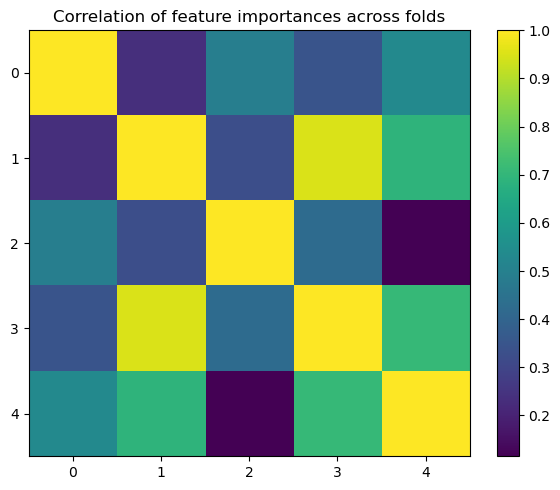

In [334]:
# --- Heatmap: correlation of feature importances across folds ---
import matplotlib.pyplot as plt
import numpy as np
import os

corr = df_imp.T.corr() if df_imp.shape[0] > 1 else None
if corr is not None:
    plt.figure(figsize=(6,5))
    im = plt.imshow(corr.values, aspect="auto")
    plt.colorbar(im)
    plt.xticks(range(len(corr.columns)), [str(c) for c in corr.columns])
    plt.yticks(range(len(corr.index)), [str(r) for r in corr.index])
    plt.title("Correlation of feature importances across folds")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "feature_importances_correlation_heatmap.png"), dpi=150)
    plt.show()
else:
    print("Correlation heatmap skipped: need at least 2 folds.")

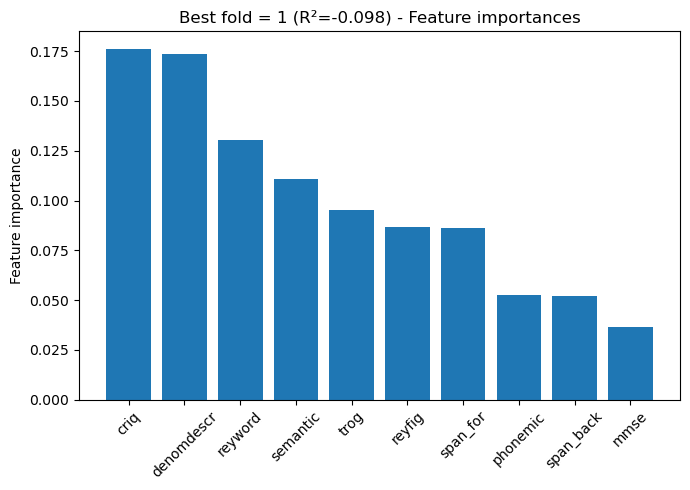

(1, -0.09820943974778218)

In [335]:
# --- Best fold by R² and its feature importances ---
import matplotlib.pyplot as plt
import os

best_idx = int(df_metrics["R2"].idxmax())
best_fold_num = int(df_metrics.loc[best_idx, "Fold"])
best_r2 = float(df_metrics.loc[best_idx, "R2"])

best_imp_series = df_imp.loc[best_fold_num-1].sort_values(ascending=False)
plt.figure(figsize=(7,5))
plt.bar(best_imp_series.index, best_imp_series.values)
plt.xticks(rotation=45)
plt.ylabel("Feature importance")
plt.title(f"Best fold = {best_fold_num} (R²={best_r2:.3f}) - Feature importances")
plt.tight_layout()
best_imp_plot = os.path.join(out_dir, f"best_fold_{best_fold_num}_feature_importances.png")
plt.savefig(best_imp_plot, dpi=150)
plt.show()

best_imp_series.to_csv(os.path.join(out_dir, f"best_fold_{best_fold_num}_feature_importances.csv"), header=["importance"])
best_fold_num, best_r2

In [336]:
%pip install tabulate

# --- Automatic interpretation (Markdown + HTML) ---
from textwrap import dedent
import os

mean_r2 = float(df_metrics["R2"].mean())
std_r2  = float(df_metrics["R2"].std())
mean_rmse = float(df_metrics["RMSE"].mean())
mean_mae  = float(df_metrics["MAE"].mean())

avg_imp_std = float(df_imp.std(axis=0).mean()) if df_imp.shape[0] > 0 else float("nan")

best_fold = rf["cv_fold_predictions"][best_fold_num-1]
y_true_b = np.array(best_fold["y_true"]).ravel()
y_pred_b = np.array(best_fold["y_pred"]).ravel()
res_b = y_true_b - y_pred_b
if len(y_pred_b) > 1 and res_b.std() > 0:
    corr_res_pred = float(np.corrcoef(y_pred_b, res_b)[0,1])
    corr_abs_res_pred = float(np.corrcoef(y_pred_b, np.abs(res_b))[0,1])
else:
    corr_res_pred = float("nan")
    corr_abs_res_pred = float("nan")
res_std = float(np.std(res_b)) if len(res_b) > 1 else float("nan")
n_outliers = int(np.sum(np.abs(res_b) > (3*res_std))) if not np.isnan(res_std) and res_std > 0 else 0

imp_stats_sorted = imp_stats.sort_values("mean_importance", ascending=False)
top3_mean = imp_stats_sorted["feature"].values[:3].tolist()
top3_mean_vals = imp_stats_sorted["mean_importance"].values[:3].tolist()
top3_best = best_imp_series.index[:3].tolist()
top3_best_vals = best_imp_series.values[:3].tolist()

def fmt_pairs(names, vals, k=3):
    return ", ".join([f"{names[i]} ({vals[i]:.3f})" for i in range(min(k, len(names)))])

# Italian interpretation for Markdown
interpretation_it = dedent(f"""
Performance complessiva
- Media R² sui fold: {mean_r2:.3f} (± {std_r2:.3f}).
- Errore medio: RMSE = {mean_rmse:.3f}, MAE = {mean_mae:.3f} (stessa unità della variabile target).

Stabilità del modello
- La variabilità del R² tra i fold è {'bassa' if std_r2 < 0.05 else 'moderata' if std_r2 < 0.15 else 'alta'} (std = {std_r2:.3f}).
- Stabilità media delle importanze tra fold: {avg_imp_std:.3f} (più basso = più stabile).

Feature più importanti (media su tutti i fold)
- Top-3: {fmt_pairs(top3_mean, top3_mean_vals, k=3)}.

Miglior fold
- Best fold: {best_fold_num} con R² = {best_r2:.3f}.
- Nella best fold le feature più importanti sono: {fmt_pairs(top3_best, top3_best_vals, k=3)}.

Analisi dei residui (best fold)
- Correlazione residui–predizioni: {corr_res_pred:.3f} (0 ≈ assenza di bias lineare).
- Correlazione |residui|–predizioni: {corr_abs_res_pred:.3f} (valori positivi indicano possibile eteroschedasticità).
- Outlier (|res| > 3·std): {n_outliers}.
""" ).strip()

# English interpretation for HTML
interpretation_en = dedent(f"""
Overall Performance
- Mean R² across folds: {mean_r2:.3f} (± {std_r2:.3f}).
- Average error: RMSE = {mean_rmse:.3f}, MAE = {mean_mae:.3f} (same unit as target variable).

Model Stability
- R² variability across folds is {'low' if std_r2 < 0.05 else 'moderate' if std_r2 < 0.15 else 'high'} (std = {std_r2:.3f}).
- Average feature importance stability across folds: {avg_imp_std:.3f} (lower = more stable).

Most Important Features (average across all folds)
- Top-3: {fmt_pairs(top3_mean, top3_mean_vals, k=3)}.

Best Fold
- Best fold: {best_fold_num} with R² = {best_r2:.3f}.
- In the best fold, the most important features are: {fmt_pairs(top3_best, top3_best_vals, k=3)}.

Residual Analysis (best fold)
- Residuals–predictions correlation: {corr_res_pred:.3f} (0 ≈ absence of linear bias).
- |Residuals|–predictions correlation: {corr_abs_res_pred:.3f} (positive values indicate possible heteroscedasticity).
- Outliers (|res| > 3·std): {n_outliers}.
""" ).strip()

# Markdown
report_md_path = os.path.join(out_dir, "mini_report_interpretation.md")
with open(report_md_path, "w", encoding="utf-8") as f:
    f.write("# Mini-report automatico: risultati CV e interpretazione\n\n")
    f.write("## Metriche per fold\n\n")
    f.write(df_metrics.to_markdown(index=False))
    f.write("\n\n## Importanze (media ± std)\n\n")
    f.write(imp_stats.to_markdown(index=False))
    f.write("\n\n## Interpretazione automatica\n\n")
    f.write(interpretation_it)
    f.write("\n")

# HTML
html_path = os.path.join(out_dir, "mini_report_interpretation.html")
html = []
html.append("<!DOCTYPE html><html><head><meta charset='utf-8'><title>CV Report</title>")
html.append("<style>body{font-family:Arial,Helvetica,sans-serif;max-width:980px;margin:2rem auto;line-height:1.5} h1,h2{margin-top:1.6rem} table{border-collapse:collapse;width:100%;} th,td{border:1px solid #ddd;padding:6px} img{max-width:100%;height:auto;margin:10px 0}</style>")
html.append("</head><body>")
html.append("<h1>Cross-Validation Results: Automatic Report and Interpretation</h1>")

html.append("<h2>Metrics by Fold</h2>")
html.append(df_metrics.to_html(index=False))

html.append("<h2>Feature Importance (mean ± std)</h2>")
html.append(imp_stats.to_html(index=False))

html.append("<h2>Main Plots</h2>")
for img in ["feature_importances_mean_std.png", "feature_importances_correlation_heatmap.png", f"best_fold_{best_fold_num}_feature_importances.png"]:
    p = os.path.join(out_dir, img)
    if os.path.exists(p):
        html.append(f"<h3>{img}</h3><img src='{img}' alt='{img}'>")

html.append("<h2>True vs Predicted Scatter Plots (by fold)</h2>")
for i in range(1, len(rf.get("cv_fold_predictions", []))+1):
    img = f"fold_{i}_true_vs_pred.png"
    if os.path.exists(os.path.join(out_dir, img)):
        html.append(f"<img src='{img}' alt='{img}'>")

html.append("<h2>Residual Plots (by fold)</h2>")
for i in range(1, len(rf.get("cv_fold_predictions", []))+1):
    img = f"fold_{i}_residuals.png"
    if os.path.exists(os.path.join(out_dir, img)):
        html.append(f"<img src='{img}' alt='{img}'>")

html.append("<h2>Automatic Interpretation</h2>")
html.append("<pre>" + interpretation_en + "</pre>")
html.append("</body></html>")

with open(html_path, "w", encoding="utf-8") as f:
    f.write("\n".join(html))

print("Saved:", report_md_path, "and", html_path)

Note: you may need to restart the kernel to use updated packages.
Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_NPSI_effectiveness/mini_report_interpretation.md and /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_NPSI_effectiveness/mini_report_interpretation.html
Note: you may need to restart the kernel to use updated packages.
Saved: /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_NPSI_effectiveness/mini_report_interpretation.md and /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_NPSI_effectiveness/mini_report_interpretation.html


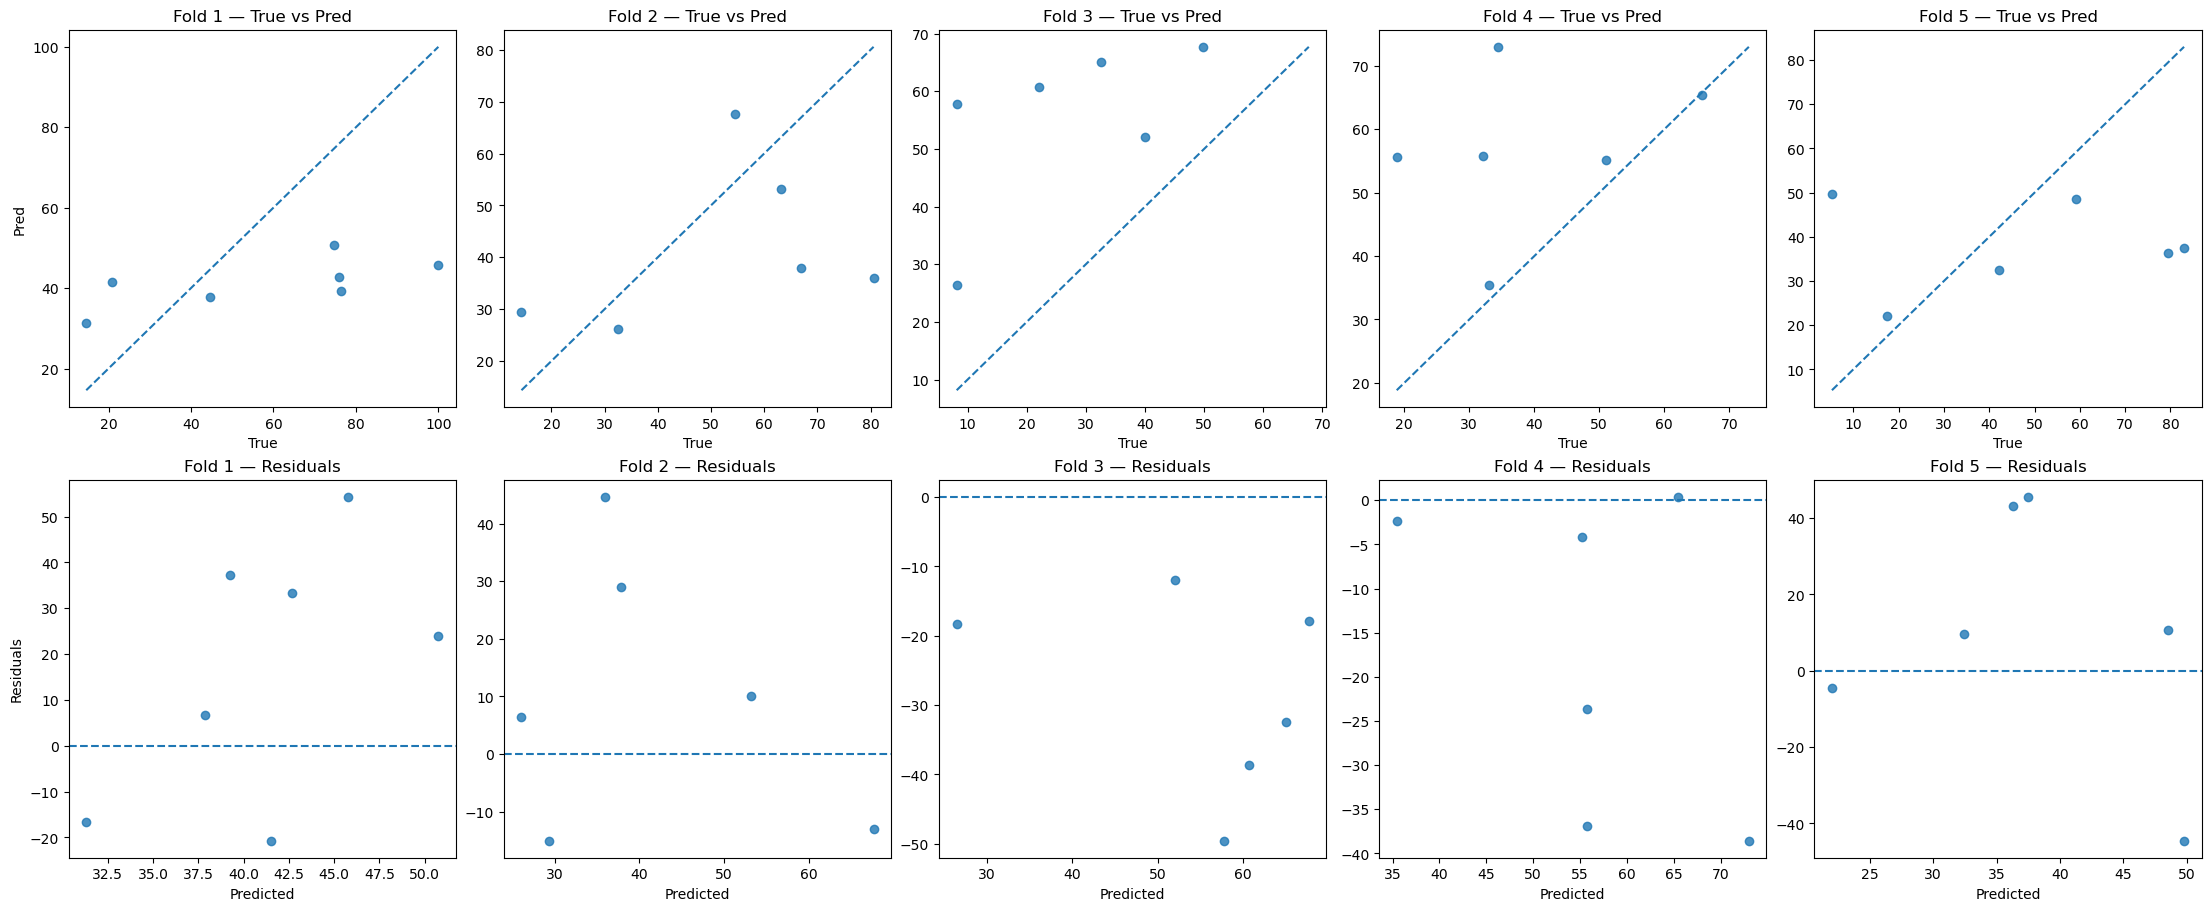

'/Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/results/univ_NPSI_effectiveness/collage_5_scatter_5_residuals.png'

In [337]:
# --- Collage: 5 scatter (top) + 5 residual (bottom) ---
import matplotlib.pyplot as plt
import numpy as np
import os

fold_preds = rf.get("cv_fold_predictions", [])
fig, axes = plt.subplots(2, 5, figsize=(22, 9), constrained_layout=True)

# Top row: scatter
for i, fold in enumerate(fold_preds):
    y_true = np.array(fold["y_true"]).ravel()
    y_pred = np.array(fold["y_pred"]).ravel()
    ax = axes[0, i]
    ax.scatter(y_true, y_pred, alpha=0.8)
    mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    ax.plot([mn, mx], [mn, mx], linestyle="--")
    ax.set_title(f"Fold {i+1} — True vs Pred")
    ax.set_xlabel("True")
    if i == 0:
        ax.set_ylabel("Pred")

# Bottom row: residuals
for i, fold in enumerate(fold_preds):
    y_true = np.array(fold["y_true"]).ravel()
    y_pred = np.array(fold["y_pred"]).ravel()
    residuals = y_true - y_pred
    ax = axes[1, i]
    ax.scatter(y_pred, residuals, alpha=0.8)
    ax.axhline(0, linestyle="--")
    ax.set_title(f"Fold {i+1} — Residuals")
    ax.set_xlabel("Predicted")
    if i == 0:
        ax.set_ylabel("Residuals")

collage_path = os.path.join(out_dir, "collage_5_scatter_5_residuals.png")
plt.savefig(collage_path, dpi=150)
plt.show()

collage_path